## NormalLVDT Simulation

In [1]:
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt

# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

#### Main Parameters

In [2]:
Description_Txt   = "LVDT ETpathfinder large IP geometry"
outputfile        = 'LVDT_10kHz_20mA_31AWG_10mm.out'
OutCoil_Distance  = 54.5 # distance between mid points of outer coils. Space between coils is then OutCoil_Distance - OutCoil_Height
InnCoil_Distance  = 0 # offset distance for inner coil
InnCoil_Current   = 0.02 # Normal LVDT: put current on inner coil
OutCoil_Current   = 0.00 # Reversed LVDT: put current on outer coils
SimulationFreq    = 10000.0 # AC frequency
NSteps            = 10
StepSize          = 1
InnCoil_Offset    = -5

# Define the problem type.  Magnetostatic; Units of mm; Axisymmetric; 
# Precision of 10^(-10) for the linear solver
femm.mi_probdef( SimulationFreq, 'millimeters', 'axi', 1.0e-10)

#### InnerCoil Parameters 

In [3]:
# 32 AWG
# InnCoil_WireType     = "32 AWG"
# InnCoil_WireDiam     = 0.2032    # with heavy build, diameter: 0.23876
# InnCoil_WireInsul    = 0.0178
# InnCoil_NrWireLayers = 6
# InnCoil_InRadius     = 11
# InnCoil_Height       = 24

# 31 AWG
InnCoil_WireType      = "31 AWG"
InnCoil_WireDiam      = 0.2261    # with heavy build, diameter: 0.26416
InnCoil_WireInsul     = 0.0190
InnCoil_NrWireLayers  =6
InnCoil_InRadius     = 11
InnCoil_Height       = 24

#### OutCoil Parameters

In [4]:

# 32 AWG
# UppOutCoil_WireType     = "32 AWG"
# UppOutCoil_WireDiam     = 0.2032
# UppOutCoil_WireInsul    = 0.0178
# UppOutCoil_NrWireLayers = 5
# UppOutCoil_InRadius     = 35
# UppOutCoil_Height       = 13.5

# LowOutCoil_WireType     = "32 AWG"
# LowOutCoil_WireDiam     = 0.2032
# LowOutCoil_WireInsul    = 0.0178
# LowOutCoil_NrWireLayers = 5
# LowOutCoil_InRadius     = 35
# LowOutCoil_Height       = 13.5



# 31 AWG
UppOutCoil_WireType     = "31 AWG"
UppOutCoil_WireDiam     = 0.2261
UppOutCoil_WireInsul    = 0.0190
UppOutCoil_NrWireLayers = 7
UppOutCoil_InRadius     = 35
UppOutCoil_Height       = 13.5

LowOutCoil_WireType     = "31 AWG"
LowOutCoil_WireDiam     = 0.2261
LowOutCoil_WireInsul    = 0.0190
LowOutCoil_NrWireLayers = 7
LowOutCoil_InRadius     = 35
LowOutCoil_Height       = 13.5

#### VoiceCoil Magnet Parameters

In [5]:
Magnet_Length    =  40
Magnet_Diameter  = 10
Magnet_Material  = "N40"
Magnet_VertShift =  0 

#### Position calculation for all Coil

In [6]:
# InnerCoil position 
InnCoil_OutRadius = InnCoil_InRadius +((InnCoil_WireDiam + InnCoil_WireInsul * 2) * InnCoil_NrWireLayers)
InnCoil_LowEnd = (InnCoil_Distance - InnCoil_Height) / 2 
InnCoil_UppEnd = InnCoil_LowEnd + InnCoil_Height
InnCoil_NrWind_p_Layer = (InnCoil_Height) / (InnCoil_WireDiam + InnCoil_WireInsul * 2)
InnCoil_NrWindings = InnCoil_NrWind_p_Layer * InnCoil_NrWireLayers
InnCoil_Circuit = "InnCoil_Circuit"

print("Inner coil:\n" 
      "Inner radius = {:.2f}".format(InnCoil_InRadius), 
      "Outer radius = {:.2f}".format(InnCoil_OutRadius),
      "Lower end = {:.2f}".format(InnCoil_LowEnd), 
      "Upper end = {:.2f}".format(InnCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(InnCoil_NrWind_p_Layer), 
      "Total windings = {:.2f}".format(InnCoil_NrWindings))

# Total length Calculation
InnCoil_TotalWire = 0
for i in range(0,InnCoil_NrWireLayers):
    #circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
    circ= 2*np.pi*(InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul*2))
    InnCoil_TotalWire += circ*InnCoil_NrWind_p_Layer    
print("Total length of wire (mm):", InnCoil_TotalWire)
print("\n")

# UppOutCoil position 
UppOutCoil_OutRadius = UppOutCoil_InRadius + ((UppOutCoil_WireDiam + UppOutCoil_WireInsul * 2) * UppOutCoil_NrWireLayers)
UppOutCoil_LowEnd = (OutCoil_Distance - UppOutCoil_Height) / 2
UppOutCoil_UppEnd = UppOutCoil_LowEnd + UppOutCoil_Height
UppOutCoil_NrWind_p_Layer = (UppOutCoil_Height) / (UppOutCoil_WireDiam + UppOutCoil_WireInsul * 2)
UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * UppOutCoil_NrWireLayers
UppOutCoil_Circuit = "UppOutCoil_Circuit"

print("Upper outer coil:\n"
      "Inner radius = {:.2f}".format(UppOutCoil_InRadius),
      "Outer radius = {:.2f}".format(UppOutCoil_OutRadius),
      "Lower end = {:.2f}".format(UppOutCoil_LowEnd),
      "Upper end = {:.2f}".format(UppOutCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(UppOutCoil_NrWind_p_Layer),
      "Total windings = {:.2f}".format(UppOutCoil_NrWindings))

# Total length Calculation
UppOutCoil_TotalWire = 0
for i in range(0,UppOutCoil_NrWireLayers):
    #circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul))
    circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul*2))
    UppOutCoil_TotalWire += circ*UppOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", UppOutCoil_TotalWire)
print("\n")

# LowOutCoil position
LowOutCoil_OutRadius = LowOutCoil_InRadius+((LowOutCoil_WireDiam+LowOutCoil_WireInsul*2)*LowOutCoil_NrWireLayers)
LowOutCoil_UppEnd = -1*(OutCoil_Distance - LowOutCoil_Height) / 2
LowOutCoil_LowEnd = LowOutCoil_UppEnd - LowOutCoil_Height
LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd-LowOutCoil_LowEnd) / (LowOutCoil_WireDiam + LowOutCoil_WireInsul * 2)
LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * LowOutCoil_NrWireLayers
LowOutCoil_Circuit = "LowOutCoil_Circuit"

print("Lower outer coil:\n"
      "Inner radius = {:.2f}".format(LowOutCoil_InRadius),
      "Outer radius = {:.2f}".format(LowOutCoil_OutRadius),
      "Lower end = {:.2f}".format(LowOutCoil_LowEnd),
      "Upper end = {:.2f}".format(LowOutCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(LowOutCoil_NrWind_p_Layer),
      "Total windings = {:.2f}".format(LowOutCoil_NrWindings))

# Total length Calculation
LowOutCoil_TotalWire = 0
for i in range(0,LowOutCoil_NrWireLayers):
    #circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
    circ = 2*np.pi*(LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul*2))
    LowOutCoil_TotalWire += circ*LowOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", LowOutCoil_TotalWire)
print("\n")

# Magnet Position
Magnet_UppEnd = Magnet_Length / 2 + Magnet_VertShift
Magnet_LowEnd = -Magnet_Length / 2 + Magnet_VertShift
Magnet_Radius = Magnet_Diameter / 2

print("Voice coil magnet:\n"
      "Magnet Radius = {:.2f}".format(Magnet_Radius),
      "Upper end = {:.2f}".format(Magnet_UppEnd),
      "Lower end = {:.2f}".format(Magnet_LowEnd))

Inner coil:
Inner radius = 11.00 Outer radius = 12.58 Lower end = -12.00 Upper end = 12.00 #Windings/layer = 90.87 Total windings = 545.25
Total length of wire (mm): 39946.78399408508


Upper outer coil:
Inner radius = 35.00 Outer radius = 36.85 Lower end = 20.50 Upper end = 34.00 #Windings/layer = 51.12 Total windings = 357.82
Total length of wire (mm): 80469.7927032582


Lower outer coil:
Inner radius = 35.00 Outer radius = 36.85 Lower end = -34.00 Upper end = -20.50 #Windings/layer = 51.12 Total windings = 357.82
Total length of wire (mm): 80469.7927032582


Voice coil magnet:
Magnet Radius = 5.00 Upper end = 20.00 Lower end = -20.00


#### Build Geometry

In [9]:
# InnerCoil Structure
femm.mi_drawrectangle(InnCoil_InRadius, InnCoil_UppEnd, InnCoil_OutRadius, InnCoil_LowEnd)
femm.mi_addcircprop(InnCoil_Circuit, InnCoil_Current, 1)
# femm.mi_getmaterial(InnCoil_WireType)
# add manually
# AWG 31
femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
femm.mi_clearselected()
femm.mi_selectrectangle(InnCoil_InRadius,InnCoil_UppEnd, InnCoil_OutRadius, InnCoil_LowEnd, 4)
femm.mi_setgroup(1)
femm.mi_clearselected()
femm.mi_addblocklabel(InnCoil_InRadius + InnCoil_WireDiam,InnCoil_LowEnd + (InnCoil_Height/2))
femm.mi_selectlabel(  InnCoil_InRadius + InnCoil_WireDiam,InnCoil_LowEnd + (InnCoil_Height/2))
femm.mi_setblockprop(InnCoil_WireType, 1, 0, InnCoil_Circuit, 0, 1 ,InnCoil_NrWindings)
femm.mi_clearselected()

# UpperOutCoil Structure
femm.mi_drawrectangle(UppOutCoil_InRadius, UppOutCoil_UppEnd, UppOutCoil_OutRadius, UppOutCoil_LowEnd)
femm.mi_addcircprop(UppOutCoil_Circuit, OutCoil_Current,1)
# femm.mi_getmaterial(UppOutCoil_WireType)
# add manually
# AWG 31
femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
femm.mi_clearselected()
femm.mi_selectrectangle(UppOutCoil_InRadius, UppOutCoil_UppEnd, UppOutCoil_OutRadius, UppOutCoil_LowEnd, 4)
femm.mi_setgroup(3)
femm.mi_clearselected()
femm.mi_addblocklabel(UppOutCoil_InRadius + UppOutCoil_WireDiam, UppOutCoil_UppEnd-(UppOutCoil_Height*0.5))
femm.mi_selectlabel(  UppOutCoil_InRadius + UppOutCoil_WireDiam, UppOutCoil_UppEnd-(UppOutCoil_Height*0.5))
femm.mi_setblockprop( UppOutCoil_WireType, 0, 0.1, UppOutCoil_Circuit, 0, 3, UppOutCoil_NrWindings)
femm.mi_clearselected()

# LowerOutCoil Structure
femm.mi_drawrectangle(LowOutCoil_InRadius,LowOutCoil_UppEnd, LowOutCoil_OutRadius, LowOutCoil_LowEnd)
femm.mi_addcircprop(LowOutCoil_Circuit, -OutCoil_Current, 1)
# femm.mi_getmaterial(LowOutCoil_WireType)
# add manually
#AWG 31
femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
femm.mi_clearselected()
femm.mi_selectrectangle(LowOutCoil_InRadius,LowOutCoil_UppEnd, LowOutCoil_OutRadius, LowOutCoil_LowEnd, 4)
femm.mi_setgroup(4)
femm.mi_clearselected()
femm.mi_addblocklabel(LowOutCoil_InRadius + LowOutCoil_WireDiam, LowOutCoil_LowEnd+(LowOutCoil_Height*0.5))
femm.mi_selectlabel(  LowOutCoil_InRadius + LowOutCoil_WireDiam, LowOutCoil_LowEnd+(LowOutCoil_Height*0.5))
femm.mi_setblockprop(LowOutCoil_WireType, 0, 0.1, LowOutCoil_Circuit, 0, 4, LowOutCoil_NrWindings)
femm.mi_clearselected()

# Magnet Structure
femm.mi_drawrectangle(0, Magnet_UppEnd, Magnet_Radius,Magnet_LowEnd)
femm.mi_getmaterial(Magnet_Material)
femm.mi_clearselected()
femm.mi_selectrectangle(0, Magnet_UppEnd, Magnet_Radius,Magnet_LowEnd, 4)
femm.mi_setgroup(2)
femm.mi_clearselected()
femm.mi_addblocklabel(Magnet_Radius*0.5, Magnet_LowEnd+(Magnet_Length*0.5))
femm.mi_selectlabel(  Magnet_Radius*0.5, Magnet_LowEnd+(Magnet_Length*0.5))
femm.mi_setblockprop(Magnet_Material, 0, 0.1, "", 90, 2, 0)
femm.mi_clearselected()

# AirSurrounding Structure
AirSpaceRadius_1 = 100
AirSpaceRadius_2 = 300
BC_Name = "Outside"
BC_Group = 10
# Airspace1
femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
femm.mi_getmaterial("Air")       
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_selectlabel(  AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
femm.mi_clearselected()
# Airspace2              
femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
femm.mi_getmaterial("Air")  
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_selectlabel(  AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
femm.mi_clearselected()
# Boundary properties
femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
femm.mi_clearselected()
femm.mi_selectarcsegment(0, AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)               
femm.mi_clearselected()

#### Start Simulation and change the inner coil position

Output variables

In [10]:
UppOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
LowOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Positions = np.zeros(NSteps+1)
MetaData = np.zeros(NSteps+1)

Initial Offset position

In [11]:
femm.mi_selectgroup(1)
femm.mi_selectgroup(2)
femm.mi_movetranslate(0, InnCoil_Offset)
femm.mi_clearselected()

Simulation loop 

In [12]:
for i in range(0,NSteps+1):

    print(InnCoil_Offset + StepSize*i)
    InnCoil_Positions[i] = InnCoil_Offset + StepSize*i

    # Now, the finished input geometry can be displayed.
    #femm.mi_zoomnatural()
    femm.mi_zoom(-2,-50,50,50)
    femm.mi_refreshview()

    # We have to give the geometry a name before we can analyze it.
    femm.mi_saveas('LVDT_Position_ETpf_LIP.fem')

    # Now,analyze the problem and load the solution when the analysis is finished
    femm.mi_analyze()
    femm.mi_loadsolution()

    if NSteps == 0:
        # Show Density Plot:
        femm.mo_showdensityplot(1, 0.0001, 0.0001, 1.0E-9, "bmag")
                #--legend,	(0=hide, 1=show)
                #--gscale,	(0=color, 1=greyscale)
                #--upper_B,	(upperlimit for display)
                #--lower_B,	(lowerlimit for display)
                #--type		("bmag", "breal", "bimag" FluxDensity)
                #--			("hmag", "hreal", "himag" FieldIntensity)
                #--			("jmag", "jreal", "jimag" CurrentDensity)
        femm.mo_zoom(-2,-50,50,50)
        femm.mo_refreshview()

    UppOutCoil_I, UppOutCoil_V, UppOutCoil_FluxLink = femm.mo_getcircuitproperties(UppOutCoil_Circuit)
    print("Upper OuterCoil: I= {:.3f}, V = {:.6f} ".format(UppOutCoil_I, UppOutCoil_V))
    UppOutCoil_Voltages[i] = UppOutCoil_V

    LowOutCoil_I, LowOutCoil_V, LowOutCoil_FluxLink = femm.mo_getcircuitproperties(LowOutCoil_Circuit)
    print("Lower OuterCoil: I= {:.3f}, V = {:.6f} ".format(LowOutCoil_I, LowOutCoil_V))
    LowOutCoil_Voltages[i] = LowOutCoil_V

    InnCoil_I, InnCoil_V, InnCoil_FluxLink = femm.mo_getcircuitproperties(InnCoil_Circuit)
    print("InnerCoil: I= {:.3f}, V = {:.8f} ".format(InnCoil_I, InnCoil_V))
    InnCoil_Voltages[i] = InnCoil_V

    # Translate inner coil to different distance
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, StepSize)
    femm.mi_clearselected()

-5
Upper OuterCoil: I= 0.000, V = 0.021559+0.786838j 
Lower OuterCoil: I= 0.000, V = 0.030633+1.160066j 
InnerCoil: I= 0.020, V = 0.47396937+5.53493759j 
-4
Upper OuterCoil: I= 0.000, V = 0.022389+0.819736j 
Lower OuterCoil: I= 0.000, V = 0.029673+1.119142j 
InnerCoil: I= 0.020, V = 0.47401231+5.54727684j 
-3
Upper OuterCoil: I= 0.000, V = 0.023245+0.853666j 
Lower OuterCoil: I= 0.000, V = 0.028724+1.078702j 
InnerCoil: I= 0.020, V = 0.47400988+5.54658877j 
-2
Upper OuterCoil: I= 0.000, V = 0.024124+0.888650j 
Lower OuterCoil: I= 0.000, V = 0.027785+1.038894j 
InnerCoil: I= 0.020, V = 0.47397988+5.53843211j 
-1
Upper OuterCoil: I= 0.000, V = 0.025015+0.924798j 
Lower OuterCoil: I= 0.000, V = 0.026847+0.999979j 
InnerCoil: I= 0.020, V = 0.47400850+5.54548582j 
0
Upper OuterCoil: I= 0.000, V = 0.025924+0.961910j 
Lower OuterCoil: I= 0.000, V = 0.025923+0.961921j 
InnerCoil: I= 0.020, V = 0.47400775+5.54608998j 
1
Upper OuterCoil: I= 0.000, V = 0.026845+0.999992j 
Lower OuterCoil: I= 0.00

In [13]:
print(InnCoil_Positions)
print(UppOutCoil_Voltages)
print(LowOutCoil_Voltages)
print(InnCoil_Voltages)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.02155928+0.78683797j 0.02238883+0.81973554j 0.02324515+0.8536659j
 0.02412426+0.8886504j  0.02501452+0.92479836j 0.02592368+0.96191038j
 0.02684486+0.99999248j 0.02778085+1.03893394j 0.02872607+1.07866969j
 0.02967915+1.11908413j 0.03062683+1.1601518j ]
[0.03063324+1.16006575j 0.02967346+1.11914248j 0.0287242 +1.07870153j
 0.02778473+1.03889441j 0.02684687+0.99997874j 0.02592286+0.9619214j
 0.02501376+0.92480106j 0.02412162+0.88869206j 0.02324672+0.85365292j
 0.02239206+0.81967426j 0.02155408+0.78689435j]
[0.47396937+5.53493759j 0.47401231+5.54727684j 0.47400988+5.54658877j
 0.47397988+5.53843211j 0.4740085 +5.54548582j 0.47400775+5.54608998j
 0.47401536+5.54767911j 0.4740072 +5.54478448j 0.47399837+5.54309545j
 0.47398813+5.53834505j 0.47400454+5.54497322j]


In [14]:
if NSteps > 2:
    MetaData[0] = NSteps
    MetaData[1] = StepSize
    MetaData[2] = InnCoil_Current
    np.savetxt(outputfile, (InnCoil_Positions, UppOutCoil_Voltages, LowOutCoil_Voltages, InnCoil_Voltages, MetaData))

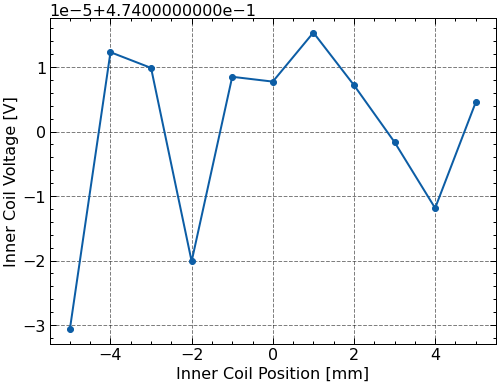

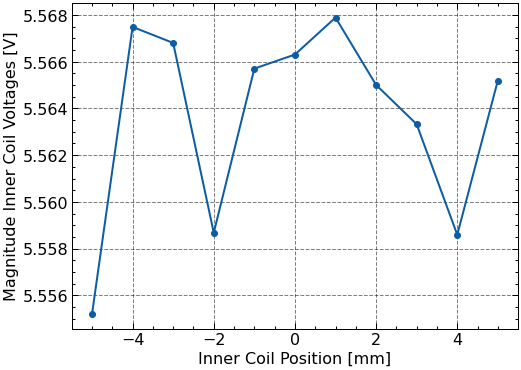

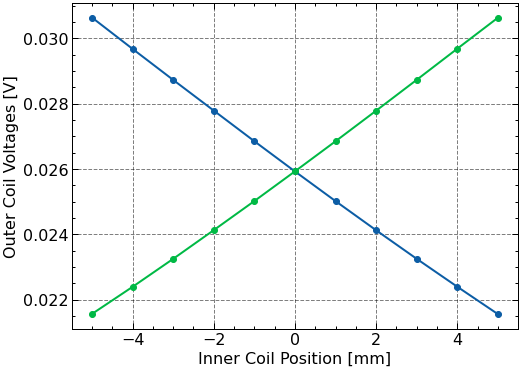

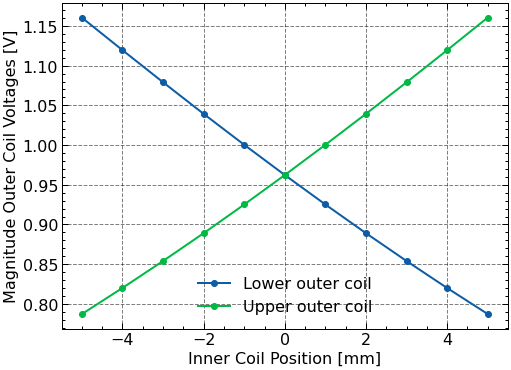

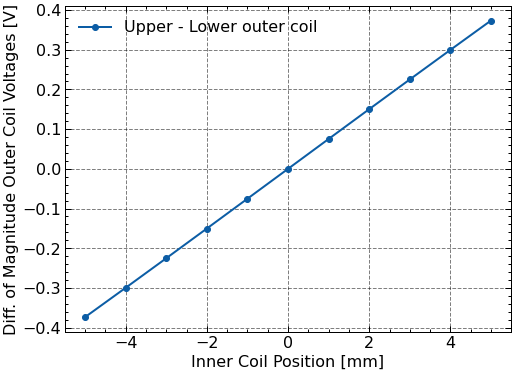

[1.48537243 1.48555384 1.48554376 1.48542419 1.48552713 1.48553651
 1.48555945 1.48551663 1.48549235 1.48542137 1.48551999]
[1.54439599 1.54428807 1.54417412 1.54405818 1.54395533 1.5438538
 1.5437552  1.54366016 1.54357101 1.54348487 1.54341184]
[1.54340328 1.54349085 1.54357325 1.54365591 1.5437543  1.54385265
 1.54395772 1.54406293 1.54417161 1.54428162 1.54440347]
Phase offset: -0.059023559926046465 -0.05888348087148909


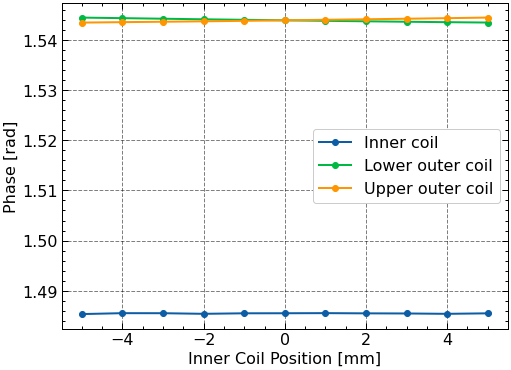

In [15]:
plt.style.use(['science','grid','notebook'])

plt.plot(InnCoil_Positions, InnCoil_Voltages.real,'o-')
plt.ylabel('Inner Coil Voltage [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(InnCoil_Voltages),'o-')
plt.ylabel('Magnitude Inner Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, LowOutCoil_Voltages.real, 'o-',label="Lower outer coil")
plt.plot(InnCoil_Positions, UppOutCoil_Voltages.real,'o-', label="Upper outer coil")
plt.ylabel('Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(LowOutCoil_Voltages),'o-', label="Lower outer coil",)
plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages),'o-', label="Upper outer coil",)
plt.ylabel('Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
plt.show()

plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages),'o-', label="Upper - Lower outer coil",)
plt.ylabel('Diff. of Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
plt.show()

InnCoil_Phases = np.angle(InnCoil_Voltages)
LowOutCoil_Phases = np.angle(LowOutCoil_Voltages)
UppOutCoil_Phases = np.angle(UppOutCoil_Voltages)
print(InnCoil_Phases)
print(LowOutCoil_Phases)
print(UppOutCoil_Phases)
print("Phase offset:", InnCoil_Phases[0] - LowOutCoil_Phases[0], InnCoil_Phases[NSteps] - UppOutCoil_Phases[NSteps])

plt.plot(InnCoil_Positions, InnCoil_Phases,'o-', label="Inner coil",)
plt.plot(InnCoil_Positions, LowOutCoil_Phases, 'o-',label="Lower outer coil",)
plt.plot(InnCoil_Positions, UppOutCoil_Phases,'o-', label="Upper outer coil",)
plt.ylabel('Phase [rad]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

Fitted slope of the function: 3.7416373973222172
[3.74163740e+00 5.28834438e-05]


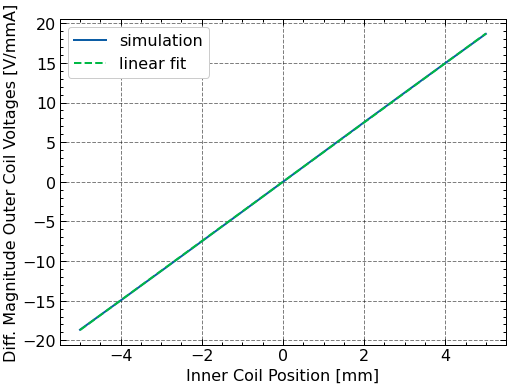

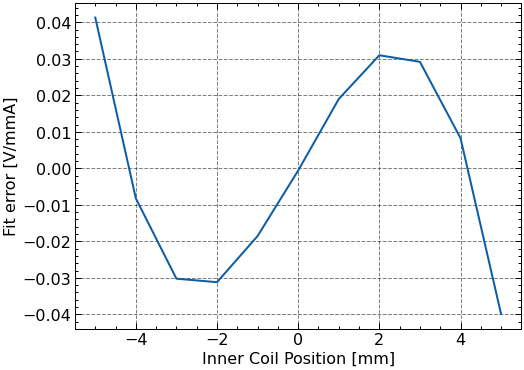

[-1.87081341e+01 -1.49664967e+01 -1.12248593e+01 -7.48322191e+00
 -3.74158451e+00  5.28834438e-05  3.74169028e+00  7.48332768e+00
  1.12249651e+01  1.49666025e+01  1.87082399e+01]
[-1.86668431e+01 -1.49747288e+01 -1.12550791e+01 -7.51440485e+00
 -3.76012257e+00 -5.49692392e-04  3.76067342e+00  7.51429674e+00
  1.12541368e+01  1.49748781e+01  1.86683248e+01]


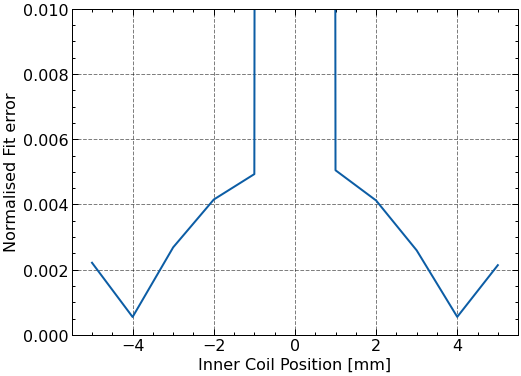

In [16]:
Norm_OutCoil_Signals = (abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages))/StepSize/InnCoil_Current

def linfunc(x, a, b):
     return a*x + b
            #ydata: Norm_OutCoil_Signals
            #xdata: InnCoil_Position

optimizedParameters, pcov = opt.curve_fit(linfunc, InnCoil_Positions, Norm_OutCoil_Signals);
print("Fitted slope of the function:",optimizedParameters[0])
fitted_Norm_OutCoil_Signals = linfunc(InnCoil_Positions, *optimizedParameters)
print(optimizedParameters)

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals, label="simulation")
plt.plot(InnCoil_Positions, fitted_Norm_OutCoil_Signals, '--', label="linear fit")
plt.ylabel('Diff. Magnitude Outer Coil Voltages [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals)
plt.ylabel('Fit error [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

print(fitted_Norm_OutCoil_Signals)
print(Norm_OutCoil_Signals)

plt.plot(InnCoil_Positions, abs(Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals)/abs(Norm_OutCoil_Signals))
plt.ylabel('Normalised Fit error')
plt.xlabel('Inner Coil Position [mm]')
plt.ylim(0.0,0.01)
plt.show()

In [21]:
femm.closefemm()